In [1]:
''' Current version of AD_OCS model. Define the input according to the defined unit of measure from the spreadsheet.
    Define the timespan in hours.'''

import math
from pprint import pprint as pp
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from SS_Algebraic import*
from dataimport import*
from PhysConstants  import*

from functions import gompertz, growth_SRB, f_deviations, deviations_check, level_t, headspace_dynamics_discr, logistic_deviations
from models import AD_OCS, AMOCO_HN
from mix_real_gas import f_VL_realgas


# System definition
d_start = 20         # [h] - Start time
d_end   = 50      # [h] - End time
hours   = 0.5      # [h] - Discretization time

n_times = int((d_end-d_start)/hours)+1  # Number of time steps

print('***Intervals of {hours} hours. \n {n_times} time steps***'.format(hours=hours, n_times=n_times))

t_span = np.linspace(d_start,d_end,n_times) # time span
t_span_d = t_span/24 # time span in days

y_influent_changes = f_deviations(t_span_d, T3.index.values, y_in_0) # Get the deviated influent values at each timestamp
y_influent = y_influent_changes[:,0:5] # Remove the Q_in values

Q_in = y_influent_changes[:,5] # Remove the y_in values

# --------------------------------------------------------------------------------------------
# Ode Integration of AMOCO_HN: use to get X2 
# --------------------------------------------------------------------------------------------

y0= [SSTATE[0], SSTATE[1], SSTATE[2], SSTATE[3], SSTATE[4], SSTATE[5], SSTATE[6]] # initial conditions esxkcdlished from SS

YOUT_pre = odeint(AMOCO_HN, y0, t_span_d, hmax = (t_span_d[1]-t_span_d[0]), args=(alfa, mu_max, Ks, KI2, KH, Pt, kLa, D, k, kd, N_bac, N_S1, y0[2], t_span[0], y_in_0, T3.index.values))
X2_pre = YOUT_pre[:,2]
S2_old = YOUT_pre[:,5]
print('************** AMOCOHN OK *******************')

# --------------------------------------------------------------------------------------------
# Ode Integration of the AD_OCS_Model: uses the previous X2 to get rho
# --------------------------------------------------------------------------------------------

y0 = [SSTATE[0], SSTATE[1], SSTATE[2], SSTATE[3], SSTATE[4], SSTATE[5], SSTATE[6]] # initial conditions esxkcdlished from SS

YOUT = odeint(AD_OCS, y0, t_span_d, hmax = (t_span_d[1]-t_span_d[0]), args=(alfa, mu_max, Ks, KI2, KH, Pt, kLa, D, k, kd, N_bac, N_S1, y0[2], t_span[0], y_in_0, T3.index.values, X2_pre, t_span_d))

# Get results
XT = YOUT[:,0]              # [gCOD/L] - Particulate 
X1 = YOUT[:,1]              # [g/L]    - Acidogenics  Bacteria  
X2 = YOUT[:,2]              # [g/L]    - Methanogenic Bacteria
Z  = YOUT[:,3]              # [mmol/L] - Total Alkalinity
S1 = YOUT[:,4]              # [g/L]    - Organic Soluble Substrate
S2 = YOUT[:,5]              # [mmol/L] - VFA dissolved
C  = YOUT[:,6]              # [mmol/L] - Inorganic Carbon Dissolved

print('************** AD_OCS OK *******************')

# Solver Output: from all the variables from the ones of the ODE
mu1 = np.empty(len(XT))
mu2 = np.empty(len(XT))
CO2 = np.empty(len(XT))
B   = np.empty(len(XT))
phi = np.empty(len(XT))
p_C = np.empty(len(XT))
q_C = np.empty(len(XT))
q_M_u = np.empty(len(XT))
pH  = np.empty(len(XT))

for x in range(len(t_span)):
    mu1[x] = mu_max[0]*(S1[x]/(S1[x]+Ks[0]))                     # [1/d]      - Specific Growth Rate for X1 (Monod)
    mu2[x] = mu_max[1]*(S2[x]/(S2[x]+Ks[1]+S2[x]**2/KI2))        # [1/d]      - Specific Growth Rate for X2 (Haldane)
    CO2[x] = C[x] + S2[x] - Z[x]                                 # [mmol/L]   - Dissolved CO2
    B[x]   = Z[x] - S2[x]                                        # [mmol/L]   - Alkalinity
    phi[x] = CO2[x] + KH*Pt + k[5]/kLa*mu2[x]*X2[x]
    p_C[x]  = (phi[x] - (phi[x]**2- 4*KH*Pt*CO2[x])**0.5)/(2*KH) # [atm]      - CO2 Partial Pressure
    q_C[x] = kLa*(CO2[x] - KH*p_C[x])                            # [mmol/L/d] - CO2 Outlet Molar Flow
    q_M_u[x] = k[5]*mu2[x]*X2[x]                                   # [mmol/L/d] - CH4 Outlet Molar Flow
    pH[x]  = np.real(-np.log10(Kb*CO2[x]/B[x]))                  # [-]        - System pH


# Sulfur and Oxygen Influence Evaluation

Xs     = np.zeros(len(t_span))                                   # [g/L]      - Sulfate Reducing Bacteria
Ss     = np.zeros(len(t_span))                                   # [mmol/L]      - Sulfur dissolved
y_S    = np.zeros(len(t_span))                                      # [-]        - Sulfur Mole fraction in gas phase
Ss_max = np.zeros(len(t_span))                                   # [mmol/L]      - Maximum Sulfur dissolved concentration
Xs_max = np.zeros(len(t_span))                                   # [g/L]      - Maximum Sulfate Reducing Bacteria concentration (Gompertz Asymptote)
mu_srb = np.zeros(len(t_span))                                   # [g/L/d]    - Gompertz parameter for SRB growth
growth_rate = np.zeros(len(t_span))                              # [g/L/d]    - Gompertz derivative: states the growth rate of SRB

dXsdt = np.zeros([len(t_span),len(t_span)])                     # [g/L/d]    - SRB growth rate matrix, preallocation
lam = 0                                                         # [-]        - Lag Time as defined by Gompertz

index = 0
for j in range(len(t_span)):
    # Iterate over each time step
        
    Ss_max[j] = frac_sulfur*1000/64*S2[j]                   #*y_influent[j,4]/y_influent[0,4]
    Xs_max[j] = Y_srb/(1-Y_srb)*Ss_max[j]     
    
    # Gompertz function for microbial population and dissolved sulfur
    mu_srb[j] = (- X2[0] + X2[j])/max(1e-14,t_span[j]-t_span[0])      # [g/L/d]    - Gompertz parameter for SRB growth
    Xs[j]  = gompertz(t_span[j], Xs_max[j], mu_srb[j], lam)           # [g/L]      - Sulfate Reducing Bacteria - Gompertz
    Ss[j]  = Xs[j]*(1-Y_srb)/(Y_srb)                                  # [g/L]      - Sulfur dissolved concentration
        
    for snapshot in range(len(t_span)):        
        mu_srb_loc = np.nan_to_num((- X2[0] + X2[snapshot])/(max(1e-14,t_span[snapshot] - t_span[0])), nan=0, neginf=0)    # [g/L/d]    - Gompertz parameter for SRB growth, local  
        dXsdt[j, snapshot] = growth_SRB(t_span[snapshot], Xs_max[j], mu_srb_loc, lam)                     # [g/L/d]    - SRB growth rate matrix, local (Gompertz Derivative)
    
        growth_rate[j] = np.nanmax(dXsdt[j])                  # [g/L/d]    - Get the growth rate of SRB at each time step as the maximum of the possible rates

    y_S[j]   = (KH_S*Ss[j])/P_dig                             # [-]        - Sulfur Mole fraction in gas phase (G/L equilibrium)

Choose a datasets: 
 1 -> AMOCO_HN 
 2 -> provaADM1 
 3 -> bsm2 
 4 -> matlab 
 5 -> thoni
Data are from: amoco_HN
mu1,max: 0.3179441566590626; Ks1:  0.3934383020566712; Cd1: 0.07145038157763807
mu2,max: 0.1395227951114702; Ks2:  3.0523454127694714; KI2: 199.2865903880199; Cd2: 0.17302628019377272
k1: [18.89428158], intercept: 0.614474830334951
k2: [815.32471023], intercept: -5.079308170919209
k3: [956.2605334], intercept: -5.079308170919209
k4: [10.46146164], intercept: 0.0
k5: [191.38876052], intercept: 0.0
k6: [252.89930627], intercept: 0.7546849933824298
k_hyd: [5.00241138], intercept: -0.6685035332106093
kLa: [23.21029151],     intercept: 2.6833587136628143,

 STEADY STATE VALUES 

S.S. of XT   0.3166804680877583
S.S. of X1   1.149200718776252
S.S. of X2   0.9585206009329962
S.S. of Z    239.74788220447437
S.S. of S1   0.11666640593408327
S.S. of S2   3.5322754028707064
S.S. of C    241.59698721271675
S.S. of CO2  5.381380411113099
S.S. of Pc   0.19651111579317454
S.S. of q_M  17.

Text(0, 0.5, 'Difference [mmol/L]')

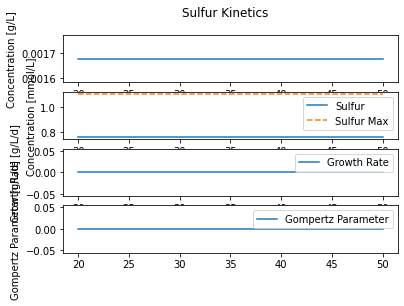

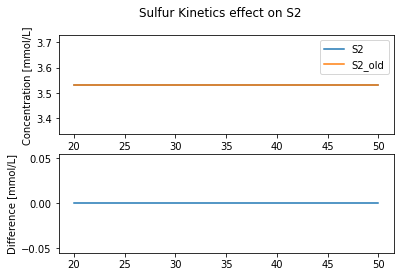

In [2]:
plt.figure()
plt.suptitle('Sulfur Kinetics')
plt.subplot(4,1,1)
plt.plot(t_span, Xs, label='SRB')
plt.ylabel(ylabel='Concentration [g/L]')
plt.subplot(4,1,2)
plt.plot(t_span, Ss, label='Sulfur')
plt.plot(t_span, Ss_max, '--', label='Sulfur Max')
plt.legend()
plt.ylabel('Concentration [mmol/L]')
plt.subplot(4,1,3)
plt.plot(t_span, growth_rate, label='Growth Rate')
plt.ylabel('Growth Rate [g/L/d]')
plt.legend()
plt.subplot(4,1,4)
plt.plot(t_span, mu_srb, label='Gompertz Parameter')
plt.ylabel('Gompertz Parameter [g/L/d]')
plt.legend()


plt.figure()
plt.suptitle('Sulfur Kinetics effect on S2')
plt.subplot(2,1,1)
plt.plot(t_span, S2, label='S2')
plt.plot(t_span, S2_old, label='S2_old')
plt.legend()
plt.ylabel('Concentration [mmol/L]')
plt.subplot(2,1,2)
plt.plot(t_span, S2-S2_old, label='S2-S2_old')
plt.ylabel('Difference [mmol/L]')
# plt.show()


In [3]:
y0 = [SSTATE[0], SSTATE[1], SSTATE[2], SSTATE[3], SSTATE[4], SSTATE[5], SSTATE[6]] # initial conditions esxkcdlished from SS

YOUT = odeint(AD_OCS, y0, t_span_d, hmax = (t_span_d[1]-t_span_d[0]), args=(alfa, mu_max, Ks, KI2, KH, Pt, kLa, D, k, kd, N_bac, N_S1, y0[2], t_span[0], y_in_0, T3.index.values, X2_pre, t_span_d))


t: 0.8333 rho_srb: 0
t: 0.8334 rho_srb: 0
t: 0.8335 rho_srb: 0
t: 0.8544 rho_srb: 0
t: 0.8752 rho_srb: 0
t: 0.896 rho_srb: 0
t: 0.9169 rho_srb: 0
t: 0.9377 rho_srb: 0
t: 0.9585 rho_srb: 0
t: 0.9794 rho_srb: 0
t: 1.0002 rho_srb: 0
t: 1.021 rho_srb: 0
t: 1.0419 rho_srb: 0
t: 1.0627 rho_srb: 0
t: 1.0835 rho_srb: 0
t: 1.1044 rho_srb: 0
t: 1.1252 rho_srb: 0
t: 1.146 rho_srb: 0
t: 1.1669 rho_srb: 0
t: 1.1877 rho_srb: 0
t: 1.2085 rho_srb: 0
t: 1.2294 rho_srb: 0
t: 1.2502 rho_srb: 0
t: 1.271 rho_srb: 0
t: 1.2919 rho_srb: 0
t: 1.3127 rho_srb: 0
t: 1.3335 rho_srb: 0
t: 1.3544 rho_srb: 0
t: 1.3752 rho_srb: 0
t: 1.396 rho_srb: 0
t: 1.4169 rho_srb: 0
t: 1.4377 rho_srb: 0
t: 1.4585 rho_srb: 0
t: 1.4794 rho_srb: 0
t: 1.5002 rho_srb: 0
t: 1.521 rho_srb: 0
t: 1.5419 rho_srb: 0
t: 1.5627 rho_srb: 0
t: 1.5835 rho_srb: 0
t: 1.6044 rho_srb: 0
t: 1.6252 rho_srb: 0
t: 1.646 rho_srb: 0
t: 1.6669 rho_srb: 0
t: 1.6877 rho_srb: 0
t: 1.7085 rho_srb: 0
t: 1.7294 rho_srb: 0
t: 1.7502 rho_srb: 0
t: 1.771 rho_srb: 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


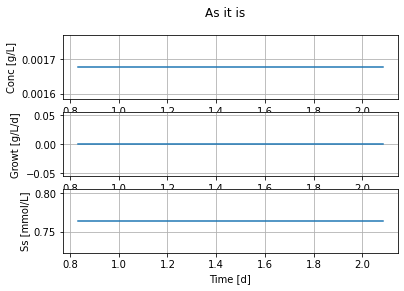

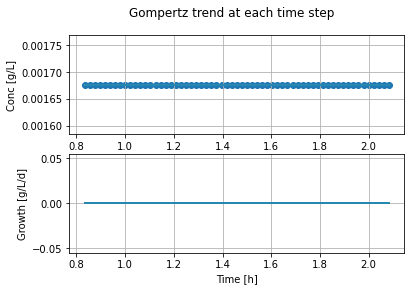

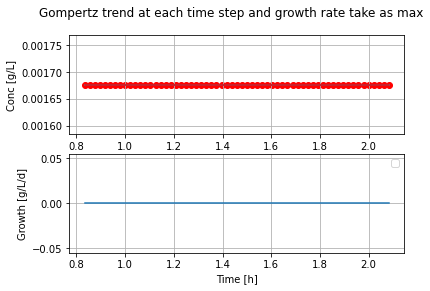

In [4]:
'''Series of codes to try things related to sulfur modeling'''

# define gompertz function
def gompertz(x,a,b,c):
    return a*np.exp(-np.exp(b*np.exp(1)/a*(c-x) - 1))

def growth_SRB(x,a,b,c):                                                                    # Growth of SRB
    return b*np.exp((np.exp(1)*b/a*(c-x))-np.exp(np.exp(1)*b/a*(c-x)+1)+2)

'''1. Model represented in the main code'''
# Sulfur production model: dSs/dt = (1-y)/y * dXs/dt

Xs_max = np.zeros(len(t_span_d))
Ss_max = np.zeros(len(t_span_d))
Xs = np.zeros(len(XT))
Ss = np.zeros(len(XT))
rho = np.zeros(len(XT))
rho_t = np.zeros(len(XT))
lam = np.zeros(len(XT))
mu_srb = np.zeros(len(XT))

for i in range(len(XT)):
    # Species differences
    Ss_max[i] = frac_sulfur*1000/64*S2[i]
    Xs_max[i] = Y_srb/(1-Y_srb)*Ss_max[i]   # maximum sulfur concentration g/L
    
    mu_srb[i] = (- X2[0] + X2[i])/max(1e-14,(t_span_d[i] - t_span_d[0]))     
    
    # Gompertz function
    Xs[i] = gompertz(t_span_d[i], Xs_max[i], mu_srb[i], 0)
    Ss[i] = Xs[i]*(1-Y_srb)/(Y_srb)
    rho[i] = growth_SRB(t_span_d[i], Xs_max[i], mu_srb[i], 0)


plt.figure(110)
plt.suptitle('As it is')
plt.subplot(3,1,1)
plt.plot(t_span_d, Xs, label="Gompertz")
# plt.plot(t_span_d, Xs_max, '--')
plt.ylabel('Conc [g/L]')
plt.grid(True)

plt.subplot(3,1,2)
plt.grid(True)
plt.plot(t_span_d, rho)

# plt.plot(t_span_d, mu_srb,'--')
plt.xlabel('Time [d]')
plt.ylabel('Growt [g/L/d]')

plt.subplot(3,1,3)
plt.grid(True)
plt.plot(t_span_d, Ss)
plt.xlabel('Time [d]')
plt.ylabel('Ss [mmol/L]')

'''2. Represent a Gompertz trend at each time step'''

size_iter = len(t_span_d)
Ss_max_ = np.zeros([size_iter])
Xs_max_ = np.zeros([size_iter])
Xs_ = np.zeros([size_iter,len(t_span_d)])
Ss_ = np.zeros([size_iter,len(t_span_d)])
rho_ = np.zeros([size_iter,len(t_span_d)])
rho_t = np.zeros([size_iter,len(t_span_d)])
lam = np.zeros([size_iter,len(t_span_d)])
mu_srb_ = np.zeros([size_iter,len(t_span_d)])

plt.figure(111)

for j in range(len(t_span_d)): 
    Ss_max_[j] = frac_sulfur*1000/64*S2[j]
    Xs_max_[j] = Y_srb/(1-Y_srb)*Ss_max[j]   # maximum sulfur concentration g/L
    
    for ii in range(len(t_span_d)):

        mu_srb_[j,ii] = (- X2[0] + X2[ii])/max(1e-14,(t_span_d[ii] - t_span_d[0]))     
    
        Xs_[j,ii]  = gompertz(t_span_d[ii], Xs_max_[j], mu_srb_[j,ii], 0)
        Ss_[j,ii]  = Xs_[j,ii]*(1-Y_srb)/(Y_srb)
        rho_[j,ii] = growth_SRB(t_span_d[ii], Xs_max_[j], mu_srb_[j,ii], 0)

    # get max of rho omitting nan
   
    plt.suptitle('Gompertz trend at each time step')

    plt.subplot(2,1,1)
    # label with the index of the time step 
    plt.plot(t_span_d, Xs_[j,:])
    # plt.plot(t_span_d, Xs_max, '--')
    plt.ylabel('Conc [g/L]')
    plt.grid(True)    

    plt.subplot(2,1,2)
    plt.grid(True)
    plt.plot(t_span_d, rho_[j,:])
    
    # plt.plot(t_span_d, mu_srb,'--')
    plt.xlabel('Time [h]')
    plt.ylabel('Growth [g/L/d]')

plt.subplot(2,1,1)
plt.scatter(t_span_d, Xs, label="Gompertz")

'''3. Get the proper trend of growth rate - max of rho'''

size_iter = len(t_span_d)
Ss_max_ = np.zeros([size_iter])
Xs_max_ = np.zeros([size_iter])
Xs_ = np.zeros([size_iter,len(t_span_d)])
Ss_ = np.zeros([size_iter,len(t_span_d)])
rho_ = np.zeros([size_iter,len(t_span_d)])
rho_true = np.zeros([size_iter])
lam = np.zeros([size_iter,len(t_span_d)])
mu_srb_ = np.zeros([size_iter,len(t_span_d)])

plt.figure(112)
plt.suptitle('Gompertz trend at each time step and growth rate take as max')

for j in range(len(t_span_d)): 
    Ss_max_[j] = frac_sulfur*1000/64*S2[j]
    Xs_max_[j] = Y_srb/(1-Y_srb)*Ss_max[j]   # maximum sulfur concentration g/L
    
    for ii in range(len(t_span_d)):

        mu_srb_[j,ii] = (- X2[0] + X2[ii])/max(1e-14,(t_span_d[ii] - t_span_d[0]))        
        Xs_[j,ii]  = gompertz(t_span_d[ii], Xs_max_[j], mu_srb_[j,ii], 0)
        Ss_[j,ii]  = Xs_[j,ii]*(1-Y_srb)/(Y_srb)
        rho_[j,ii] = growth_SRB(t_span_d[ii], Xs_max_[j], mu_srb_[j,ii], 0)
    
    rho_true[j] = np.nanmax(rho_[j]) # get max of rho omitting nan     

    plt.subplot(2,1,1)
    # label with the index of the time step 
    plt.plot(t_span_d, Xs_[j,:])
    # plt.plot(t_span_d, Xs_max, '--')
    plt.ylabel('Conc [g/L]')
    plt.grid(True)    

plt.subplot(2,1,2)
plt.grid(True)
plt.plot(t_span_d, rho_true)
plt.legend(ncol=2)
# plt.plot(t_span_d, mu_srb,'--')
plt.xlabel('Time [h]')
plt.ylabel('Growth [g/L/d]')
#
plt.subplot(2,1,1)
plt.scatter(t_span_d, Xs, color='red', label="Gompertz")
plt.plot(t_span_d, Xs, color = 'red', label="Gompertz")

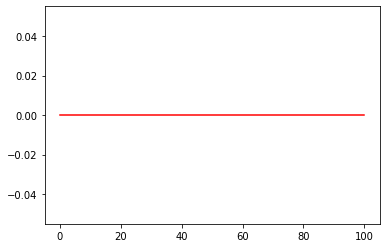

In [5]:
tvett = np.linspace(0, 100, 100)
plt.plot(tvett, growth_SRB(tvett, Xsmax_[0], mu_srb_[0,0], 0), color = 'red', label="Gompertz")_
